In [59]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [14]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
recent_date

'2017-08-23'

In [22]:
# Calculate the date one year from the last date in data set.
recent_obj = dt.datetime.strptime(recent_date, '%Y-%m-%d')
one_year_ago = recent_obj - dt.timedelta(days=366)
one_year_ago


datetime.datetime(2016, 8, 22, 0, 0)

In [23]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

In [73]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [76]:
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [75]:
# Sort the dataframe by date
sorted_df = precipitation_df.sort_values(by='Date')
sorted_df

,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


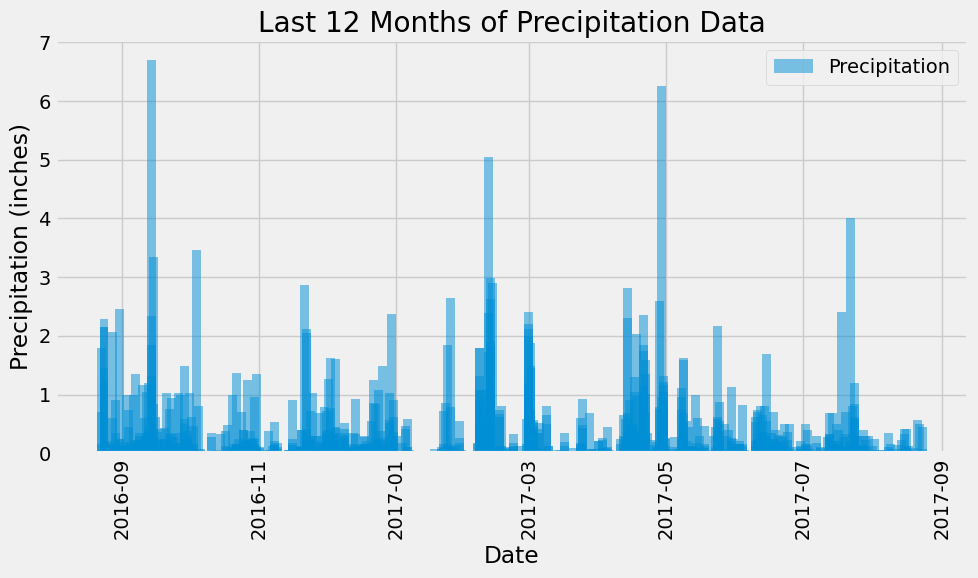

In [80]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
#plot the data of the df
plt.bar(sorted_df['Date'], sorted_df['Precipitation'], width=4, alpha=0.5, align='center', label='Precipitation')

#set up for the plot
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

#save the png image
plt.savefig('Output/precipitation_plot.png')


plt.show()


In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats =sorted_df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [82]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [85]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                                group_by(measurement.station).\
                                order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [86]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = 'USC00519281'

temperature_stats = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs)).filter(measurement.station == most_active_id).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

In [87]:

#query the date and temperature data using as filter the id of the station and the 12 months time
station_query = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_id).\
                filter(measurement.date >= one_year_ago).all()

#pass the query to a pd dataframe for the plot        
station_df = pd.DataFrame(station_query, columns=['Date', 'Temperature'])
station_df

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


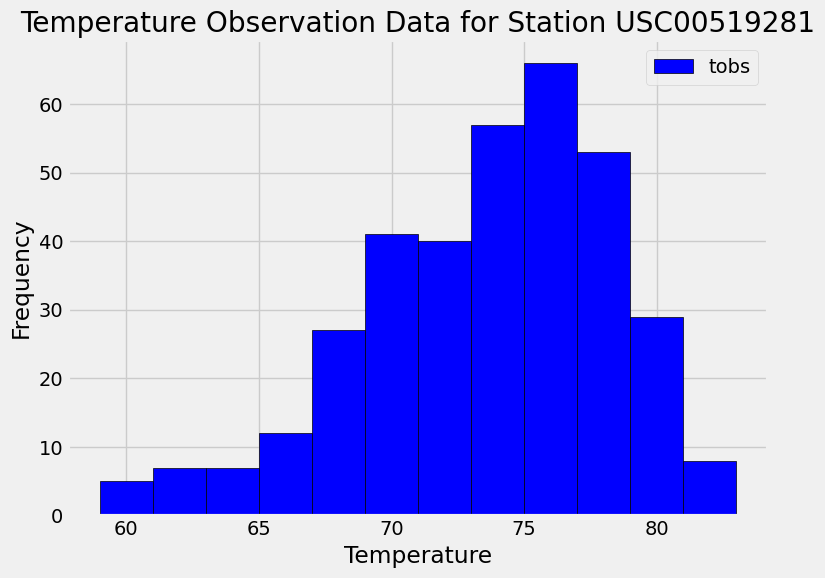

In [92]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(station_df['Temperature'], bins=12, color='blue', edgecolor='black', label='tobs')
plt.title(f'Temperature Observation Data for Station {most_active_id}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()

#save the fig and show the plot
plt.savefig('Output/temperature_plot.png')
plt.show()

# Close Session

In [94]:
# Close Session
session.close()